# Gemma2-27B Attention Analysis

This notebook analyzes how instruction tuning modifies attention patterns for PC and semantic vectors.

**Key Analyses:**
1. **QK Affinity**: Raw attention logits (before softmax) reveal semantic affinities
2. **VO Decomposition**: What semantic content flows through when attending to a vector
3. **Base vs Instruct Comparison**: How instruction tuning changes routing

**Approach:**
- Compute QK affinity matrices for PC and semantic vectors
- Compute VO decomposition (value-output transformation)
- Analyze z-scores relative to random baseline
- Identify layers and patterns where instruction tuning has strongest effect

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoConfig
from collections import OrderedDict

from chatspace.analysis import (
    load_pca_data,
    extract_pc_components,
    load_individual_role_vectors,
    load_individual_trait_vectors,
    normalize_vector,
    compute_qk_affinity_matrix,
    compute_vo_decomposition,
    compute_z_score_matrices,
    get_top_interactions,
    analyze_pc_pattern
)

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Models and Prepare Vectors

In [3]:
# Load models
base_model_id = "google/gemma-2-27b"
instruct_model_id = "google/gemma-2-27b-it"

print("Loading models...")
config = AutoConfig.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16, device_map="cpu")
instruct_model = AutoModelForCausalLM.from_pretrained(instruct_model_id, torch_dtype=torch.bfloat16, device_map="cpu")
print("✓ Models loaded")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading models...


Loading checkpoint shards:   0%|          | 0/24 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Models loaded


In [38]:
# Load PC vectors
persona_data_root = Path("/workspace/persona-data")
roles_pca_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "pca"
traits_pca_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "pca"

pca_data, _ = load_pca_data(roles_pca_dir)
pcs, variance_explained = extract_pc_components(pca_data, n_components=3)
pca_layer = pca_data['layer']

# Load individual role and trait vectors at the same layer as PCA
roles_vectors_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "vectors"
traits_vectors_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "vectors"

print(f"Loading role and trait vectors at layer {pca_layer}...")
role_vectors = load_individual_role_vectors(roles_vectors_dir, pca_layer, max_roles=10)
trait_vectors = load_individual_trait_vectors(traits_vectors_dir, pca_layer, max_traits=10)

print(f"  ✓ Loaded {len(role_vectors)} role difference vectors")
print(f"  ✓ Loaded {len(trait_vectors)} trait contrast vectors")

# Build test vectors
test_vectors = OrderedDict()

# Add PC vectors
test_vectors['PC1'] = normalize_vector(pcs[0])
test_vectors['PC2'] = normalize_vector(pcs[1])
test_vectors['PC3'] = normalize_vector(pcs[2])
test_vectors['-PC1'] = normalize_vector(-pcs[0].float())

# Add sample role vectors
for name, vec in list(role_vectors.items())[:5]:
    test_vectors[f'role:{name}'] = vec

# Add sample trait vectors
for name, vec in list(trait_vectors.items())[:5]:
    test_vectors[f'trait:{name}'] = vec

# Add random baseline
torch.manual_seed(42)
for i in range(32):
    rand_vec = torch.randn(config.hidden_size, dtype=torch.float32)
    test_vectors[f'Random{i+1}'] = normalize_vector(rand_vec)

vector_names = list(test_vectors.keys())
vectors_tensor = torch.stack([test_vectors[name] for name in vector_names])

print(f"\n✓ Prepared {len(vector_names)} test vectors")
print(f"  PC vectors: {len([n for n in vector_names if 'PC' in n])}")
print(f"  Role vectors: {len([n for n in vector_names if 'role:' in n])}")
print(f"  Trait vectors: {len([n for n in vector_names if 'trait:' in n])}")
print(f"  Random vectors: {len([n for n in vector_names if 'Random' in n])}")

Loading role and trait vectors at layer 22...
  ✓ Loaded 10 role difference vectors
  ✓ Loaded 10 trait contrast vectors

✓ Prepared 46 test vectors
  PC vectors: 4
  Role vectors: 5
  Trait vectors: 5
  Random vectors: 32


/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2. Compute QK Affinity Matrices

QK affinities reveal which vectors semantically "attend to" each other (before softmax).

In [39]:
# Compute QK affinities for target layers
target_layers = list(range(17, 27))
n_vectors = len(vector_names)

qk_base = np.zeros((len(target_layers), n_vectors, n_vectors))
qk_instruct = np.zeros((len(target_layers), n_vectors, n_vectors))

print(f"Computing QK affinities for layers {target_layers}...")

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(target_layers)):
        qk_b = compute_qk_affinity_matrix(vectors_tensor, layer_idx, base_model)
        qk_i = compute_qk_affinity_matrix(vectors_tensor, layer_idx, instruct_model)
        qk_base[i] = qk_b.cpu().numpy()
        qk_instruct[i] = qk_i.cpu().numpy()

qk_delta = qk_instruct - qk_base
print(f"\n✓ QK affinity computation complete")
print(f"  Shape: {qk_base.shape}")

Computing QK affinities for layers [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]...


100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


✓ QK affinity computation complete
  Shape: (10, 46, 46)


In [40]:
# Compute z-scores relative to random baseline
random_indices = [vector_names.index(n) for n in vector_names if 'Random' in n]
qk_delta_z = compute_z_score_matrices(qk_delta, random_indices)

print(f"✓ Z-score normalization complete")
print(f"\nExample z-scores at layer 18 (index 1):")
if 'PC1' in vector_names:
    pc1_idx = vector_names.index('PC1')
    print(f"  PC1→PC1:  {qk_delta_z[1, pc1_idx, pc1_idx]:.2f}σ")
    print(f"  PC1→-PC1: {qk_delta_z[1, pc1_idx, vector_names.index('-PC1')]:.2f}σ")

✓ Z-score normalization complete

Example z-scores at layer 18 (index 1):
  PC1→PC1:  -1.35σ
  PC1→-PC1: 1.34σ


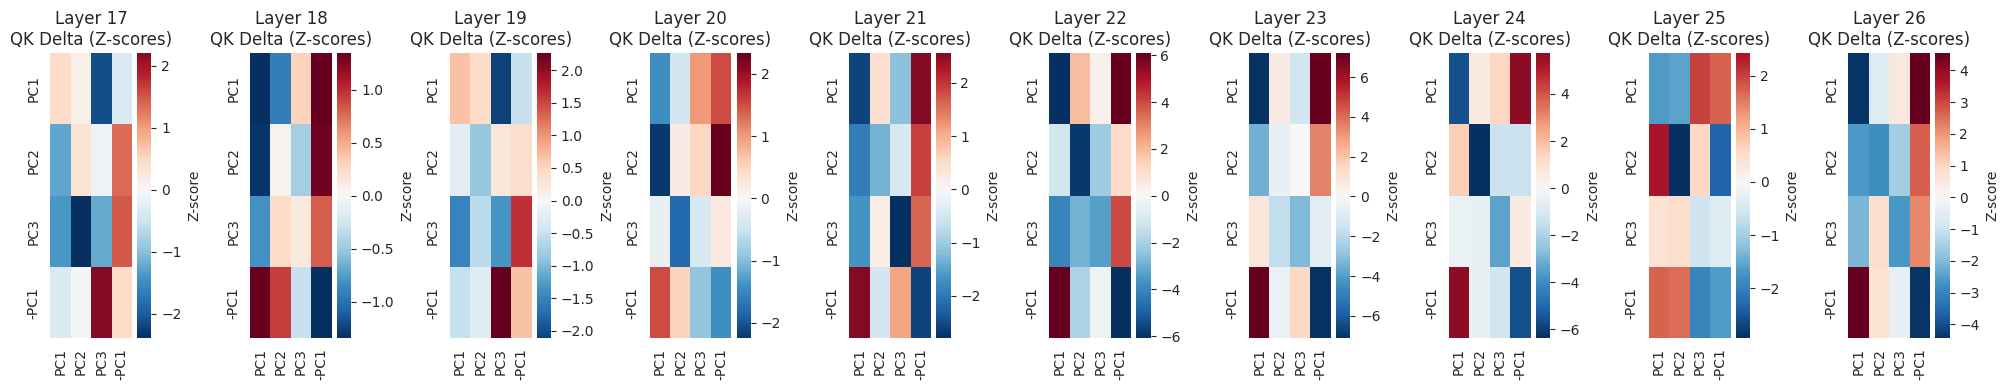

In [41]:
# Visualize QK affinity changes
fig, axes = plt.subplots(1, len(target_layers), figsize=(20, 4))

for i, layer_idx in enumerate(target_layers):
    # Show only PC vectors for clarity
    pc_indices = [vector_names.index(n) for n in vector_names if 'PC' in n]
    pc_names = [vector_names[j] for j in pc_indices]
    
    matrix = qk_delta_z[i][np.ix_(pc_indices, pc_indices)]
    
    sns.heatmap(matrix, ax=axes[i], cmap='RdBu_r', center=0, 
                xticklabels=pc_names, yticklabels=pc_names,
                cbar_kws={'label': 'Z-score'})
    axes[i].set_title(f'Layer {layer_idx}\nQK Delta (Z-scores)')

plt.tight_layout()
plt.show()

## 3. Compute VO Decomposition

VO decomposition reveals what semantic content flows through when attending to a vector.

In [42]:
# Compute VO decomposition
vo_base = np.zeros((len(target_layers), n_vectors, n_vectors))
vo_instruct = np.zeros((len(target_layers), n_vectors, n_vectors))

print(f"Computing VO decomposition for layers {target_layers}...")

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(target_layers)):
        vo_b = compute_vo_decomposition(vectors_tensor, vectors_tensor, layer_idx, base_model)
        vo_i = compute_vo_decomposition(vectors_tensor, vectors_tensor, layer_idx, instruct_model)
        vo_base[i] = vo_b.cpu().numpy()
        vo_instruct[i] = vo_i.cpu().numpy()

vo_delta = vo_instruct - vo_base
vo_delta_z = compute_z_score_matrices(vo_delta, random_indices)

print(f"\n✓ VO decomposition complete")
print(f"  Shape: {vo_base.shape}")

Computing VO decomposition for layers [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]...


100%|██████████| 10/10 [00:01<00:00,  8.96it/s]


✓ VO decomposition complete
  Shape: (10, 46, 46)


In [43]:
# Analyze top VO patterns
print("\n" + "="*80)
print("TOP VO DECOMPOSITION CHANGES (Layer 18)")
print("="*80)

target_layer_idx = target_layers.index(18)
top_vo = get_top_interactions(vo_delta_z, vector_names, target_layer_idx, top_k=10, exclude_self=True)
print("\nTop 10 VO changes (what semantic content flows when attending):")
print(top_vo.to_string(index=False))


TOP VO DECOMPOSITION CHANGES (Layer 18)

Top 10 VO changes (what semantic content flows when attending):
 rank               query                 key     value
    1                -PC1          role:actor 45.263675
    2      trait:abstract          role:actor 40.486890
    3      trait:abstract      role:absurdist 36.789519
    4             Random6          role:actor 36.014234
    5      trait:abstract       trait:acerbic 33.732403
    6                -PC1 trait:accommodating 33.642996
    7 trait:accommodating     role:accountant 33.328903
    8             Random6       trait:acerbic 32.699417
    9      trait:abstract       role:activist 32.618394
   10      role:absurdist    trait:accessible 31.749510


## 4. PC1-Specific Analysis

Focus on how PC1 attention patterns change with instruction tuning.

In [44]:
# Analyze PC1 patterns across layers
if 'PC1' in vector_names:
    pc1_qk = analyze_pc_pattern(qk_delta_z, vector_names, 'PC1', target_layer_idx, top_k=10)
    pc1_vo = analyze_pc_pattern(vo_delta_z, vector_names, 'PC1', target_layer_idx, top_k=10)
    
    print("\n" + "="*80)
    print("PC1 ATTENTION PATTERNS (Layer 18)")
    print("="*80)
    
    print("\nQK Affinity (what PC1 attends to):")
    print(pc1_qk.to_string(index=False))
    
    print("\nVO Decomposition (what flows through when attending to PC1):")
    print(pc1_vo.to_string(index=False))


PC1 ATTENTION PATTERNS (Layer 18)

QK Affinity (what PC1 attends to):
 rank   target    value
    1 Random31 2.032883
    2  Random2 1.648422
    3  Random9 1.643636
    4     -PC1 1.344887
    5 Random10 1.233284
    6 Random20 0.926627
    7  Random3 0.416096
    8 Random21 0.363939
    9 Random11 0.324945
   10      PC3 0.309499

VO Decomposition (what flows through when attending to PC1):
 rank           target     value
    1 trait:accessible 15.571672
    2 trait:absolutist  7.233979
    3              PC1  5.765361
    4         Random21  4.025174
    5          Random4  3.943728
    6         Random20  2.899259
    7         Random24  2.393616
    8         Random28  2.237729
    9          Random5  1.804160
   10          Random3  1.685657


## 5. PC Attention Patterns Across All Layers

Analyze how PCs attend to themselves and their opposites across all layers, normalized by random baseline.

In [45]:
# Compute QK affinity and VO decomposition for PCs across ALL layers
print("Computing PC attention patterns across all layers...")

all_layers = list(range(config.num_hidden_layers))  # All 46 layers
n_random = 20  # Use 20 random vectors for robust baseline

# Build test vectors: PCs + random baseline
test_vecs_all_layers = OrderedDict()
test_vecs_all_layers["PC1"] = normalize_vector(pcs[0])
test_vecs_all_layers["PC2"] = normalize_vector(pcs[1])
test_vecs_all_layers["PC3"] = normalize_vector(pcs[2])
test_vecs_all_layers["-PC1"] = normalize_vector(-pcs[0].float())
test_vecs_all_layers["-PC2"] = normalize_vector(-pcs[1].float())
test_vecs_all_layers["-PC3"] = normalize_vector(-pcs[2].float())

# Add 20 random vectors
torch.manual_seed(42)
for i in range(n_random):
    rand_vec = torch.randn(config.hidden_size, dtype=torch.float32)
    test_vecs_all_layers[f"Random{i+1}"] = normalize_vector(rand_vec)

vec_names_all = list(test_vecs_all_layers.keys())
vecs_tensor_all = torch.stack([test_vecs_all_layers[name] for name in vec_names_all])

print(f"✓ Prepared {len(vec_names_all)} vectors (6 PCs + {n_random} random)")
print(f"  Will analyze {len(all_layers)} layers...")

Computing PC attention patterns across all layers...
✓ Prepared 26 vectors (6 PCs + 20 random)
  Will analyze 46 layers...


In [46]:
# Compute QK and VO for all layers
n_vecs = len(vec_names_all)
qk_base_all = np.zeros((len(all_layers), n_vecs, n_vecs))
qk_inst_all = np.zeros((len(all_layers), n_vecs, n_vecs))
vo_base_all = np.zeros((len(all_layers), n_vecs, n_vecs))
vo_inst_all = np.zeros((len(all_layers), n_vecs, n_vecs))

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(all_layers, desc="Computing attention patterns")):
        # QK affinity
        qk_b = compute_qk_affinity_matrix(vecs_tensor_all, layer_idx, base_model)
        qk_i = compute_qk_affinity_matrix(vecs_tensor_all, layer_idx, instruct_model)
        qk_base_all[i] = qk_b.cpu().numpy()
        qk_inst_all[i] = qk_i.cpu().numpy()
        
        # VO decomposition
        vo_b = compute_vo_decomposition(vecs_tensor_all, vecs_tensor_all, layer_idx, base_model)
        vo_i = compute_vo_decomposition(vecs_tensor_all, vecs_tensor_all, layer_idx, instruct_model)
        vo_base_all[i] = vo_b.cpu().numpy()
        vo_inst_all[i] = vo_i.cpu().numpy()

qk_delta_all = qk_inst_all - qk_base_all
vo_delta_all = vo_inst_all - vo_base_all

print(f"\n✓ Computed QK and VO for {len(all_layers)} layers")

Computing attention patterns: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]


✓ Computed QK and VO for 46 layers


In [47]:
# Extract self-attention and opposite-attention for PCs (both positive and negative)
pc_pairs = [("PC1", "-PC1"), ("PC2", "-PC2"), ("PC3", "-PC3")]
random_indices_all = [vec_names_all.index(n) for n in vec_names_all if "Random" in n]

# For each model (base and instruct), compute PC patterns
qk_results_base = {}
qk_results_inst = {}
vo_results_base = {}
vo_results_inst = {}

for pc_pos, pc_neg in pc_pairs:
    idx_pos = vec_names_all.index(pc_pos)
    idx_neg = vec_names_all.index(pc_neg)
    
    # Positive PC patterns (PC1→PC1, PC1→-PC1)
    qk_results_base[pc_pos] = {
        "self": qk_base_all[:, idx_pos, idx_pos],
        "opposite": qk_base_all[:, idx_pos, idx_neg]
    }
    vo_results_base[pc_pos] = {
        "self": vo_base_all[:, idx_pos, idx_pos],
        "opposite": vo_base_all[:, idx_pos, idx_neg]
    }
    qk_results_inst[pc_pos] = {
        "self": qk_inst_all[:, idx_pos, idx_pos],
        "opposite": qk_inst_all[:, idx_pos, idx_neg]
    }
    vo_results_inst[pc_pos] = {
        "self": vo_inst_all[:, idx_pos, idx_pos],
        "opposite": vo_inst_all[:, idx_pos, idx_neg]
    }
    
    # Negative PC patterns (-PC1→-PC1, -PC1→PC1)
    qk_results_base[pc_neg] = {
        "self": qk_base_all[:, idx_neg, idx_neg],
        "opposite": qk_base_all[:, idx_neg, idx_pos]
    }
    vo_results_base[pc_neg] = {
        "self": vo_base_all[:, idx_neg, idx_neg],
        "opposite": vo_base_all[:, idx_neg, idx_pos]
    }
    qk_results_inst[pc_neg] = {
        "self": qk_inst_all[:, idx_neg, idx_neg],
        "opposite": qk_inst_all[:, idx_neg, idx_pos]
    }
    vo_results_inst[pc_neg] = {
        "self": vo_inst_all[:, idx_neg, idx_neg],
        "opposite": vo_inst_all[:, idx_neg, idx_pos]
    }

# Compute random baselines for EACH model separately
print("Computing random baselines for base and instruct models...")

# Base model random baseline
qk_random_base = []
vo_random_base = []
for rand_idx in random_indices_all:
    qk_random_base.append(qk_base_all[:, rand_idx, rand_idx])
    vo_random_base.append(vo_base_all[:, rand_idx, rand_idx])
qk_random_base = np.array(qk_random_base)
vo_random_base = np.array(vo_random_base)
qk_base_mean = qk_random_base.mean(axis=0)
qk_base_std = qk_random_base.std(axis=0)
vo_base_mean = vo_random_base.mean(axis=0)
vo_base_std = vo_random_base.std(axis=0)

# Instruct model random baseline
qk_random_inst = []
vo_random_inst = []
for rand_idx in random_indices_all:
    qk_random_inst.append(qk_inst_all[:, rand_idx, rand_idx])
    vo_random_inst.append(vo_inst_all[:, rand_idx, rand_idx])
qk_random_inst = np.array(qk_random_inst)
vo_random_inst = np.array(vo_random_inst)
qk_inst_mean = qk_random_inst.mean(axis=0)
qk_inst_std = qk_random_inst.std(axis=0)
vo_inst_mean = vo_random_inst.mean(axis=0)
vo_inst_std = vo_random_inst.std(axis=0)

# Convert to z-scores (each model normalized by its own random baseline)
qk_zscores_base = {}
qk_zscores_inst = {}
vo_zscores_base = {}
vo_zscores_inst = {}

for pc in ["PC1", "PC2", "PC3", "-PC1", "-PC2", "-PC3"]:
    qk_zscores_base[pc] = {
        "self": (qk_results_base[pc]["self"] - qk_base_mean) / (qk_base_std + 1e-8),
        "opposite": (qk_results_base[pc]["opposite"] - qk_base_mean) / (qk_base_std + 1e-8)
    }
    qk_zscores_inst[pc] = {
        "self": (qk_results_inst[pc]["self"] - qk_inst_mean) / (qk_inst_std + 1e-8),
        "opposite": (qk_results_inst[pc]["opposite"] - qk_inst_mean) / (qk_inst_std + 1e-8)
    }
    vo_zscores_base[pc] = {
        "self": (vo_results_base[pc]["self"] - vo_base_mean) / (vo_base_std + 1e-8),
        "opposite": (vo_results_base[pc]["opposite"] - vo_base_mean) / (vo_base_std + 1e-8)
    }
    vo_zscores_inst[pc] = {
        "self": (vo_results_inst[pc]["self"] - vo_inst_mean) / (vo_inst_std + 1e-8),
        "opposite": (vo_results_inst[pc]["opposite"] - vo_inst_mean) / (vo_inst_std + 1e-8)
    }

print(f"✓ Computed z-scores for base and instruct models")
print(f"  Each normalized by {len(random_indices_all)} random vectors through that model")
print(f"  Analyzing both positive PCs (PC1/2/3) and negative PCs (-PC1/2/3)")

Computing random baselines for base and instruct models...
✓ Computed z-scores for base and instruct models
  Each normalized by 20 random vectors through that model
  Analyzing both positive PCs (PC1/2/3) and negative PCs (-PC1/2/3)


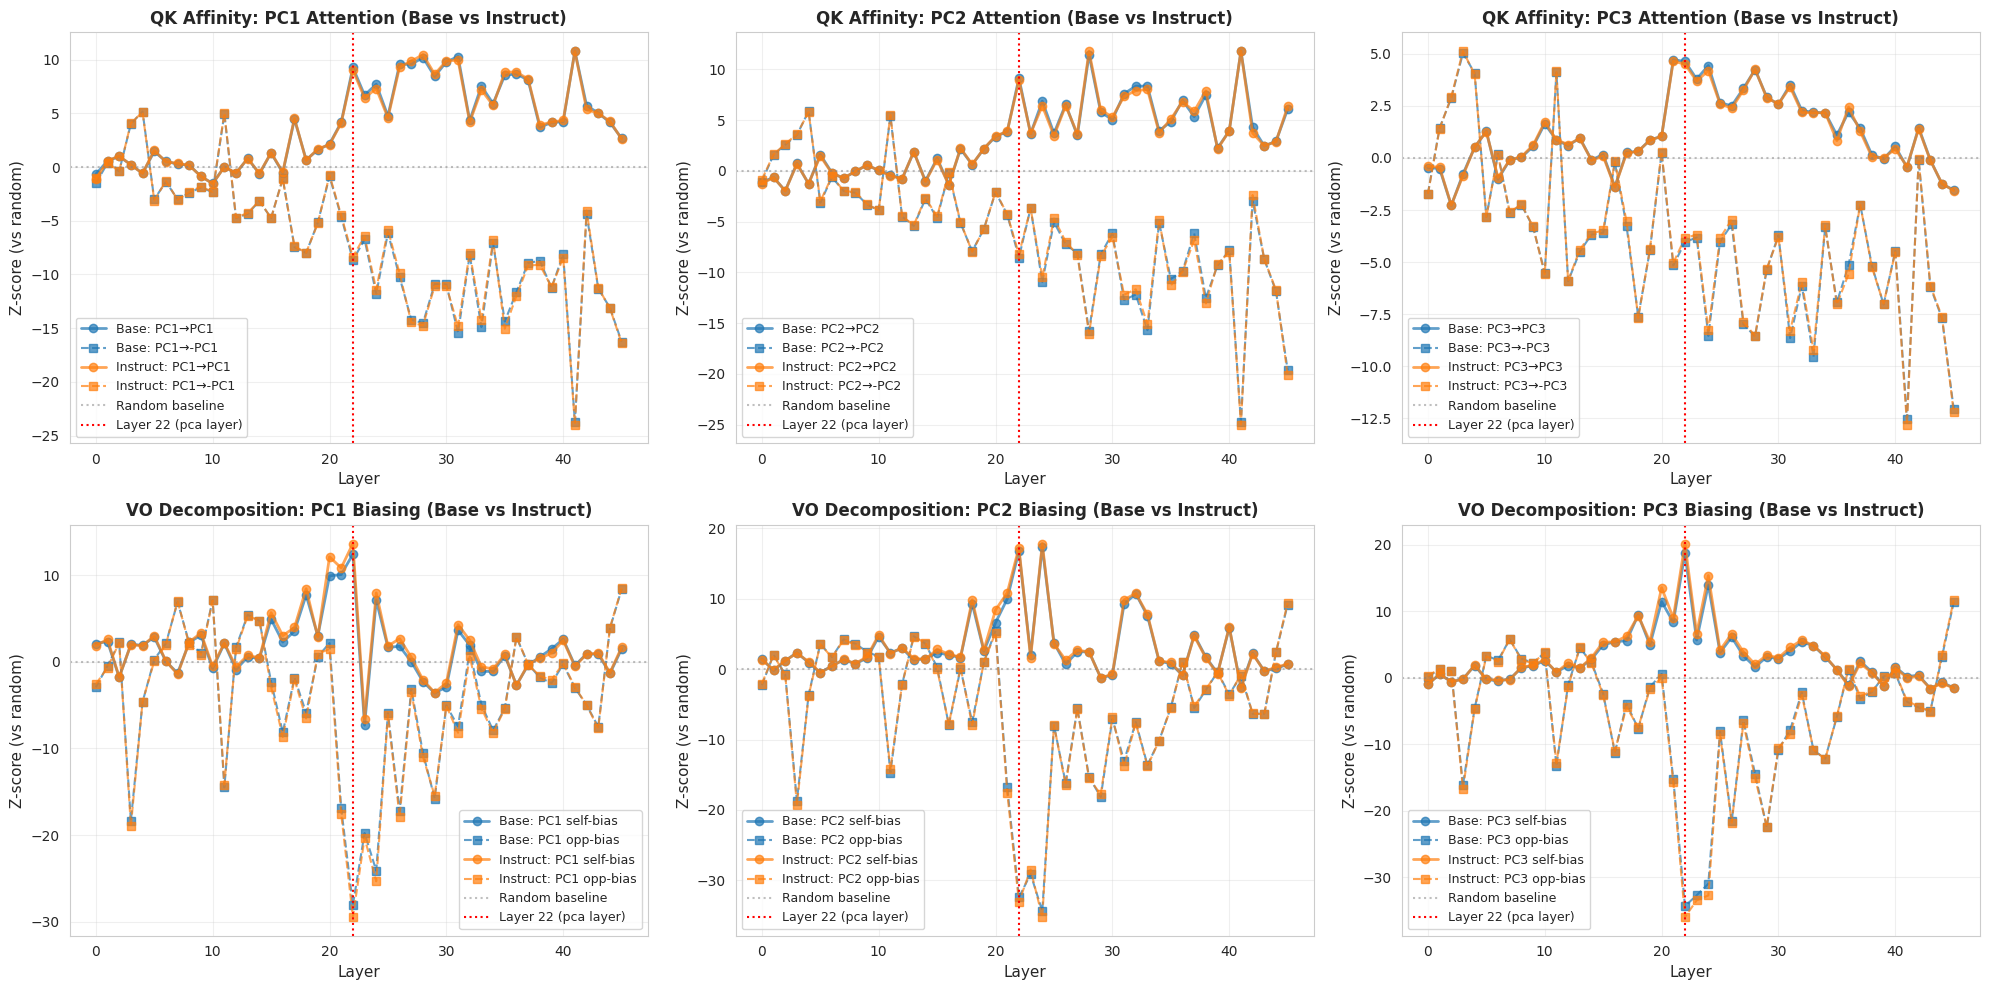


📊 Key Observations:
  - Blue (C0): Base model attention patterns
  - Orange (C1): Instruct model attention patterns
  - Solid lines: Self-attention/bias (PC→PC)
  - Dashed lines: Opposite-attention/bias (PC→-PC)
  - Each model normalized by its own random baseline
  - Positive z-scores: PC pattern stronger than random for that model
  - Compare blue vs orange to see instruction tuning effects


In [56]:
# Visualize base vs instruct attention patterns

plot_pcs = ["PC1", "PC2", "PC3"]
# plot_pcs = ["PC1"] 

fig, axes = plt.subplots(2, len(plot_pcs), figsize=(20, 10))

# QK Affinity plots (top row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[0]
    else:
        ax = axes[0, i]
    
    # Plot base model
    ax.plot(all_layers, qk_zscores_base[pc]["self"], "o-", 
            label=f"Base: {pc}→{pc}", linewidth=2, alpha=0.7, color="C0")
    ax.plot(all_layers, qk_zscores_base[pc]["opposite"], "s--", 
            label=f"Base: {pc}→-{pc}", linewidth=1.5, alpha=0.7, color="C0")
    
    # Plot instruct model
    ax.plot(all_layers, qk_zscores_inst[pc]["self"], "o-", 
            label=f"Instruct: {pc}→{pc}", linewidth=2, alpha=0.7, color="C1")
    ax.plot(all_layers, qk_zscores_inst[pc]["opposite"], "s--", 
            label=f"Instruct: {pc}→-{pc}", linewidth=1.5, alpha=0.7, color="C1")
    
    ax.axhline(0, color="gray", linestyle=":", alpha=0.5, label="Random baseline")
    ax.axvline(22, color="red", linestyle=":", alpha=1.0, label="Layer 22 (pca layer)")
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Z-score (vs random)", fontsize=11)
    ax.set_title(f"QK Affinity: {pc} Attention (Base vs Instruct)", fontsize=12, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

# VO Decomposition plots (bottom row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[1]
    else:
        ax = axes[1, i]
    
    # Plot base model
    ax.plot(all_layers, vo_zscores_base[pc]["self"], "o-", 
            label=f"Base: {pc} self-bias", linewidth=2, alpha=0.7, color="C0")
    ax.plot(all_layers, vo_zscores_base[pc]["opposite"], "s--", 
            label=f"Base: {pc} opp-bias", linewidth=1.5, alpha=0.7, color="C0")
    
    # Plot instruct model
    ax.plot(all_layers, vo_zscores_inst[pc]["self"], "o-", 
            label=f"Instruct: {pc} self-bias", linewidth=2, alpha=0.7, color="C1")
    ax.plot(all_layers, vo_zscores_inst[pc]["opposite"], "s--", 
            label=f"Instruct: {pc} opp-bias", linewidth=1.5, alpha=0.7, color="C1")
    
    ax.axhline(0, color="gray", linestyle=":", alpha=0.5, label="Random baseline")
    ax.axvline(22, color="red", linestyle=":", alpha=1.0, label="Layer 22 (pca layer)")
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Z-score (vs random)", fontsize=11)
    ax.set_title(f"VO Decomposition: {pc} Biasing (Base vs Instruct)", fontsize=12, fontweight="bold")
    ax.legend(fontsize=9, loc="best")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Key Observations:")
print(f"  - Blue (C0): Base model attention patterns")
print(f"  - Orange (C1): Instruct model attention patterns")
print(f"  - Solid lines: Self-attention/bias (PC→PC)")
print(f"  - Dashed lines: Opposite-attention/bias (PC→-PC)")
print(f"  - Each model normalized by its own random baseline")
print(f"  - Positive z-scores: PC pattern stronger than random for that model")
print(f"  - Compare blue vs orange to see instruction tuning effects")

Computing instruction tuning effects (Instruct - Base)...


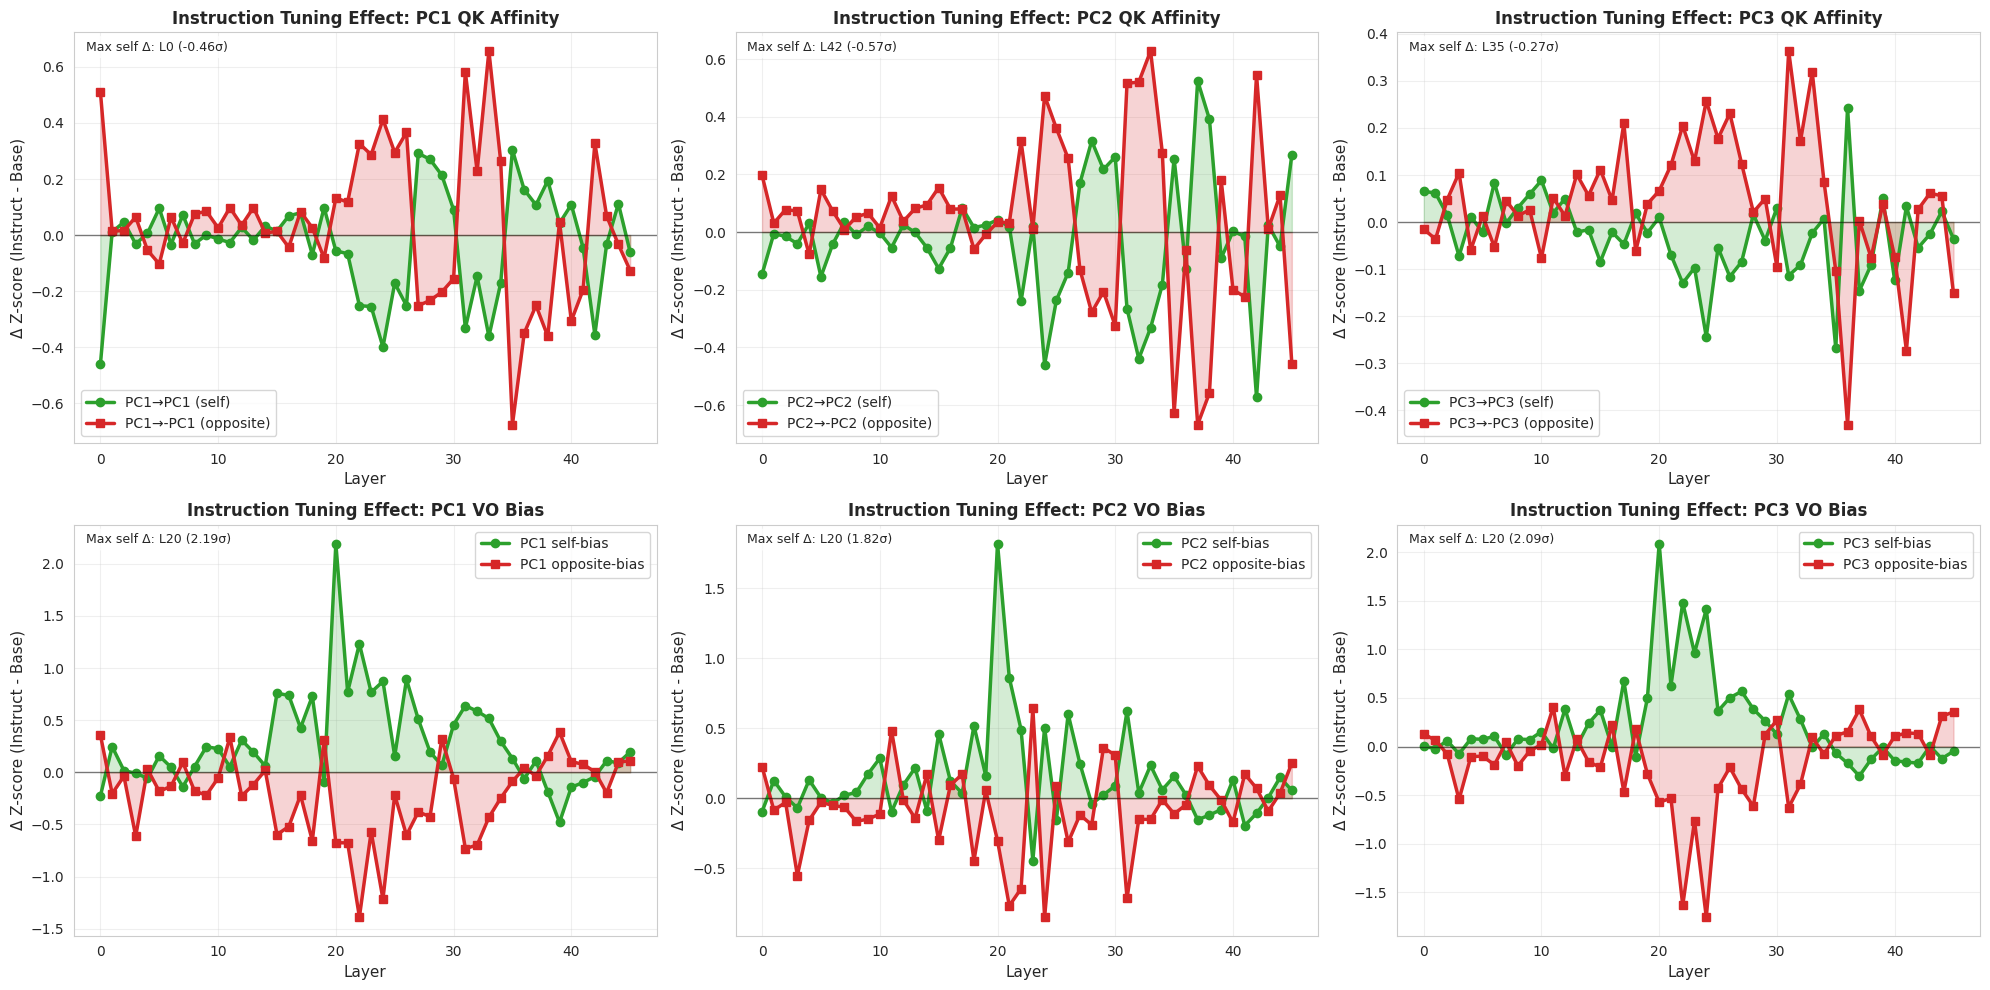


🎯 Instruction Tuning Effects:
  - Positive Δ: Instruct model has STRONGER pattern than base
  - Negative Δ: Instruct model has WEAKER pattern than base
  - Green: Self-attention/bias changes
  - Red: Opposite-attention/bias changes
  - Shaded areas show magnitude of change
  - Text boxes show layer with maximum absolute change


In [57]:
# Compute delta (Instruct - Base) for self-attention and opposite-attention
print("Computing instruction tuning effects (Instruct - Base)...")

qk_delta_zscores = {}
vo_delta_zscores = {}

for pc in plot_pcs:  # Use same PC list as visualization
    qk_delta_zscores[pc] = {
        "self": qk_zscores_inst[pc]["self"] - qk_zscores_base[pc]["self"],
        "opposite": qk_zscores_inst[pc]["opposite"] - qk_zscores_base[pc]["opposite"]
    }
    vo_delta_zscores[pc] = {
        "self": vo_zscores_inst[pc]["self"] - vo_zscores_base[pc]["self"],
        "opposite": vo_zscores_inst[pc]["opposite"] - vo_zscores_base[pc]["opposite"]
    }

# Visualize instruction tuning effects
fig, axes = plt.subplots(2, len(plot_pcs), figsize=(20, 10))

# QK Affinity deltas (top row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[0]
    else:
        ax = axes[0, i]
    
    ax.plot(all_layers, qk_delta_zscores[pc]["self"], "o-", 
            label=f"{pc}→{pc} (self)", linewidth=2.5, color="C2")
    ax.plot(all_layers, qk_delta_zscores[pc]["opposite"], "s-", 
            label=f"{pc}→-{pc} (opposite)", linewidth=2.5, color="C3")
    
    ax.axhline(0, color="black", linestyle="-", alpha=0.5, linewidth=1)
    ax.fill_between(all_layers, 0, qk_delta_zscores[pc]["self"], 
                    alpha=0.2, color="C2")
    ax.fill_between(all_layers, 0, qk_delta_zscores[pc]["opposite"], 
                    alpha=0.2, color="C3")
    
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Δ Z-score (Instruct - Base)", fontsize=11)
    ax.set_title(f"Instruction Tuning Effect: {pc} QK Affinity", fontsize=12, fontweight="bold")
    ax.legend(fontsize=10, loc="best")
    ax.grid(True, alpha=0.3)
    
    # Add text annotations for max changes
    max_self_idx = np.argmax(np.abs(qk_delta_zscores[pc]["self"]))
    ax.text(0.02, 0.98, f"Max self Δ: L{max_self_idx} ({qk_delta_zscores[pc]['self'][max_self_idx]:.2f}σ)",
            transform=ax.transAxes, fontsize=9, verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# VO Decomposition deltas (bottom row)
for i, pc in enumerate(plot_pcs):
    if len(plot_pcs) == 1:
        ax = axes[1]
    else:
        ax = axes[1, i]
    
    ax.plot(all_layers, vo_delta_zscores[pc]["self"], "o-", 
            label=f"{pc} self-bias", linewidth=2.5, color="C2")
    ax.plot(all_layers, vo_delta_zscores[pc]["opposite"], "s-", 
            label=f"{pc} opposite-bias", linewidth=2.5, color="C3")
    
    ax.axhline(0, color="black", linestyle="-", alpha=0.5, linewidth=1)
    ax.fill_between(all_layers, 0, vo_delta_zscores[pc]["self"], 
                    alpha=0.2, color="C2")
    ax.fill_between(all_layers, 0, vo_delta_zscores[pc]["opposite"], 
                    alpha=0.2, color="C3")
    
    ax.set_xlabel("Layer", fontsize=11)
    ax.set_ylabel("Δ Z-score (Instruct - Base)", fontsize=11)
    ax.set_title(f"Instruction Tuning Effect: {pc} VO Bias", fontsize=12, fontweight="bold")
    ax.legend(fontsize=10, loc="best")
    ax.grid(True, alpha=0.3)
    
    # Add text annotations for max changes
    max_self_idx = np.argmax(np.abs(vo_delta_zscores[pc]["self"]))
    ax.text(0.02, 0.98, f"Max self Δ: L{max_self_idx} ({vo_delta_zscores[pc]['self'][max_self_idx]:.2f}σ)",
            transform=ax.transAxes, fontsize=9, verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n🎯 Instruction Tuning Effects:")
print(f"  - Positive Δ: Instruct model has STRONGER pattern than base")
print(f"  - Negative Δ: Instruct model has WEAKER pattern than base")
print(f"  - Green: Self-attention/bias changes")
print(f"  - Red: Opposite-attention/bias changes")
print(f"  - Shaded areas show magnitude of change")
print(f"  - Text boxes show layer with maximum absolute change")

Comparing instruction tuning effects: PC1 vs PC2 vs PC3 across layers...


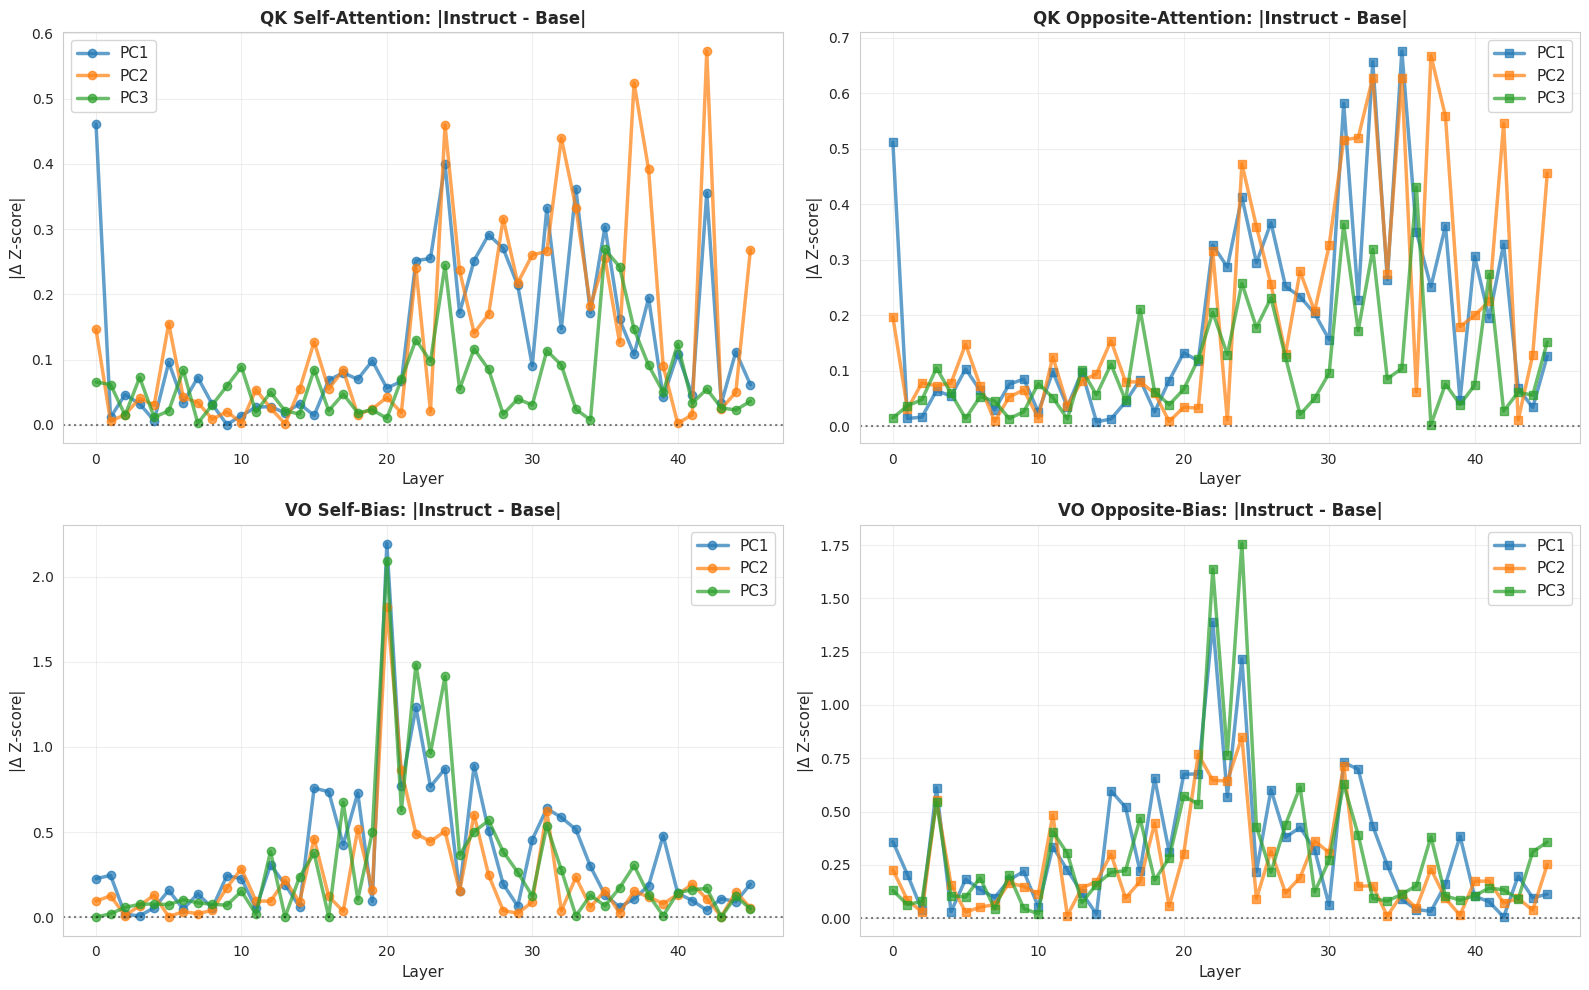


📊 Instruction Tuning Effect Magnitude (RMS across layers):

QK Self-Attention:
  PC1: 0.179σ
  PC2: 0.209σ
  PC3: 0.090σ

VO Self-Bias:
  PC1: 0.539σ
  PC2: 0.378σ
  PC3: 0.523σ

🎯 Key Finding:
  Strongest QK effect: PC2 (0.209σ)
  Strongest VO effect: PC1 (0.539σ)
  ~ PC1 shows strongest effects in VO but not both


In [61]:
# Compare instruction tuning effects across PC numbers
print("Analyzing instruction tuning effects across PC1-PC10...")

# We need to compute more PCs and their effects
# Extract more PC components from PCA data
n_pcs = 10
pcs_extended, variance_extended = extract_pc_components(pca_data, n_components=n_pcs)

print(f"✓ Extracted {n_pcs} PCs")
print(f"  Variance explained: {variance_extended[:5]}")

# Build test vectors for all PCs
test_vecs_pcs = OrderedDict()
for pc_idx in range(n_pcs):
    test_vecs_pcs[f"PC{pc_idx+1}"] = normalize_vector(pcs_extended[pc_idx])
    test_vecs_pcs[f"-PC{pc_idx+1}"] = normalize_vector(-pcs_extended[pc_idx].float())

# Add random baseline (reuse same seed for consistency)
torch.manual_seed(42)
n_random = 20
for i in range(n_random):
    rand_vec = torch.randn(config.hidden_size, dtype=torch.float32)
    test_vecs_pcs[f"Random{i+1}"] = normalize_vector(rand_vec)

vec_names_pcs = list(test_vecs_pcs.keys())
vecs_tensor_pcs = torch.stack([test_vecs_pcs[name] for name in vec_names_pcs])

print(f"✓ Prepared {len(vec_names_pcs)} vectors ({n_pcs*2} PCs + {n_random} random)")

# Compute QK and VO for target layers only (17-27)
target_layers_analysis = list(range(17, 28))
n_vecs_pcs = len(vec_names_pcs)
qk_base_pcs = np.zeros((len(target_layers_analysis), n_vecs_pcs, n_vecs_pcs))
qk_inst_pcs = np.zeros((len(target_layers_analysis), n_vecs_pcs, n_vecs_pcs))
vo_base_pcs = np.zeros((len(target_layers_analysis), n_vecs_pcs, n_vecs_pcs))
vo_inst_pcs = np.zeros((len(target_layers_analysis), n_vecs_pcs, n_vecs_pcs))

print(f"Computing QK and VO for layers {target_layers_analysis[0]}-{target_layers_analysis[-1]}...")

with torch.inference_mode():
    for i, layer_idx in enumerate(tqdm(target_layers_analysis, desc="Computing PC analysis")):
        qk_b = compute_qk_affinity_matrix(vecs_tensor_pcs, layer_idx, base_model)
        qk_i = compute_qk_affinity_matrix(vecs_tensor_pcs, layer_idx, instruct_model)
        qk_base_pcs[i] = qk_b.cpu().numpy()
        qk_inst_pcs[i] = qk_i.cpu().numpy()
        
        vo_b = compute_vo_decomposition(vecs_tensor_pcs, vecs_tensor_pcs, layer_idx, base_model)
        vo_i = compute_vo_decomposition(vecs_tensor_pcs, vecs_tensor_pcs, layer_idx, instruct_model)
        vo_base_pcs[i] = vo_b.cpu().numpy()
        vo_inst_pcs[i] = vo_i.cpu().numpy()

print(f"✓ Computed attention patterns for {len(target_layers_analysis)} layers")

# Compute random baselines
random_indices_pcs = [vec_names_pcs.index(n) for n in vec_names_pcs if "Random" in n]

qk_random_base_pcs = []
vo_random_base_pcs = []
for rand_idx in random_indices_pcs:
    qk_random_base_pcs.append(qk_base_pcs[:, rand_idx, rand_idx])
    vo_random_base_pcs.append(vo_base_pcs[:, rand_idx, rand_idx])
qk_random_base_pcs = np.array(qk_random_base_pcs)
vo_random_base_pcs = np.array(vo_random_base_pcs)
qk_base_mean_pcs = qk_random_base_pcs.mean(axis=0)
qk_base_std_pcs = qk_random_base_pcs.std(axis=0)
vo_base_mean_pcs = vo_random_base_pcs.mean(axis=0)
vo_base_std_pcs = vo_random_base_pcs.std(axis=0)

qk_random_inst_pcs = []
vo_random_inst_pcs = []
for rand_idx in random_indices_pcs:
    qk_random_inst_pcs.append(qk_inst_pcs[:, rand_idx, rand_idx])
    vo_random_inst_pcs.append(vo_inst_pcs[:, rand_idx, rand_idx])
qk_random_inst_pcs = np.array(qk_random_inst_pcs)
vo_random_inst_pcs = np.array(vo_random_inst_pcs)
qk_inst_mean_pcs = qk_random_inst_pcs.mean(axis=0)
qk_inst_std_pcs = qk_random_inst_pcs.std(axis=0)
vo_inst_mean_pcs = vo_random_inst_pcs.mean(axis=0)
vo_inst_std_pcs = vo_random_inst_pcs.std(axis=0)

# Compute z-scores and deltas for each PC
pc_effects = []
for pc_idx in range(n_pcs):
    pc_name = f"PC{pc_idx+1}"
    pc_pos_idx = vec_names_pcs.index(pc_name)
    pc_neg_idx = vec_names_pcs.index(f"-{pc_name}")
    
    # QK patterns
    qk_base_self = (qk_base_pcs[:, pc_pos_idx, pc_pos_idx] - qk_base_mean_pcs) / (qk_base_std_pcs + 1e-8)
    qk_inst_self = (qk_inst_pcs[:, pc_pos_idx, pc_pos_idx] - qk_inst_mean_pcs) / (qk_inst_std_pcs + 1e-8)
    qk_delta_self = qk_inst_self - qk_base_self
    
    qk_base_opp = (qk_base_pcs[:, pc_pos_idx, pc_neg_idx] - qk_base_mean_pcs) / (qk_base_std_pcs + 1e-8)
    qk_inst_opp = (qk_inst_pcs[:, pc_pos_idx, pc_neg_idx] - qk_inst_mean_pcs) / (qk_inst_std_pcs + 1e-8)
    qk_delta_opp = qk_inst_opp - qk_base_opp
    
    # VO patterns
    vo_base_self = (vo_base_pcs[:, pc_pos_idx, pc_pos_idx] - vo_base_mean_pcs) / (vo_base_std_pcs + 1e-8)
    vo_inst_self = (vo_inst_pcs[:, pc_pos_idx, pc_pos_idx] - vo_inst_mean_pcs) / (vo_inst_std_pcs + 1e-8)
    vo_delta_self = vo_inst_self - vo_base_self
    
    vo_base_opp = (vo_base_pcs[:, pc_pos_idx, pc_neg_idx] - vo_base_mean_pcs) / (vo_base_std_pcs + 1e-8)
    vo_inst_opp = (vo_inst_pcs[:, pc_pos_idx, pc_neg_idx] - vo_inst_mean_pcs) / (vo_inst_std_pcs + 1e-8)
    vo_delta_opp = vo_inst_opp - vo_base_opp
    
    # Take mean absolute delta across layers
    pc_effects.append({
        'pc_num': pc_idx + 1,
        'variance_explained': float(variance_extended[pc_idx]),
        'qk_self': np.mean(np.abs(qk_delta_self)),
        'qk_opposite': np.mean(np.abs(qk_delta_opp)),
        'vo_self': np.mean(np.abs(vo_delta_self)),
        'vo_opposite': np.mean(np.abs(vo_delta_opp)),
    })

print(f"✓ Computed mean effects across layers {target_layers_analysis[0]}-{target_layers_analysis[-1]}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pc_nums = [d['pc_num'] for d in pc_effects]
qk_self = [d['qk_self'] for d in pc_effects]
qk_opp = [d['qk_opposite'] for d in pc_effects]
vo_self = [d['vo_self'] for d in pc_effects]
vo_opp = [d['vo_opposite'] for d in pc_effects]

# QK plot
ax = axes[0]
ax.plot(pc_nums, qk_self, 'o-', label='Self-attention', linewidth=2.5, markersize=8, color='C2')
ax.plot(pc_nums, qk_opp, 's-', label='Opposite-attention', linewidth=2.5, markersize=8, color='C3')
ax.set_xlabel('PC Number', fontsize=12)
ax.set_ylabel('Mean |Δ Z-score| (layers 17-27)', fontsize=12)
ax.set_title('QK Affinity: Instruction Tuning Effect by PC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(pc_nums)

# VO plot
ax = axes[1]
ax.plot(pc_nums, vo_self, 'o-', label='Self-bias', linewidth=2.5, markersize=8, color='C2')
ax.plot(pc_nums, vo_opp, 's-', label='Opposite-bias', linewidth=2.5, markersize=8, color='C3')
ax.set_xlabel('PC Number', fontsize=12)
ax.set_ylabel('Mean |Δ Z-score| (layers 17-27)', fontsize=12)
ax.set_title('VO Decomposition: Instruction Tuning Effect by PC', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(pc_nums)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n📊 Instruction Tuning Effects by PC (mean |Δ Z-score| across layers 17-27):")
print(f"\n{'PC':<5} {'Var%':<8} {'QK Self':<10} {'QK Opp':<10} {'VO Self':<10} {'VO Opp':<10}")
print("=" * 65)
for d in pc_effects:
    print(f"PC{d['pc_num']:<3} {d['variance_explained']*100:>6.2f}%  "
          f"{d['qk_self']:>8.3f}σ  {d['qk_opposite']:>8.3f}σ  "
          f"{d['vo_self']:>8.3f}σ  {d['vo_opposite']:>8.3f}σ")

print(f"\n🎯 Key Finding:")
max_qk = max(pc_effects, key=lambda x: x['qk_self'])
max_vo = max(pc_effects, key=lambda x: x['vo_self'])
print(f"  Strongest QK self-attention effect: PC{max_qk['pc_num']} ({max_qk['qk_self']:.3f}σ)")
print(f"  Strongest VO self-bias effect: PC{max_vo['pc_num']} ({max_vo['vo_self']:.3f}σ)")
if max_qk['pc_num'] == 1 and max_vo['pc_num'] == 1:
    print(f"  ✓ PC1 (dominant variance) also shows strongest instruction tuning effects!")
else:
    print(f"  ✗ Instruction tuning effects do NOT align with variance ranking")

## 6. Role and Trait Attention Patterns

Analyze how instruction tuning affects attention routing for specific role and trait vectors.

In [59]:
# Analyze role and trait attention patterns
role_names = [n for n in vector_names if n.startswith("role:")]
trait_names = [n for n in vector_names if n.startswith("trait:")]

if role_names:
    print("=" * 80)
    print("ROLE VECTOR ATTENTION PATTERNS (Layer 18)")
    print("=" * 80)
    
    for role_name in role_names[:3]:  # Show first 3 roles
        role_qk = analyze_pc_pattern(qk_delta_z, vector_names, role_name, target_layer_idx, top_k=5)
        role_vo = analyze_pc_pattern(vo_delta_z, vector_names, role_name, target_layer_idx, top_k=5)
        
        print(f"\n{role_name}:")
        print(f"  QK top 5: {role_qk['target'].head(5).tolist()}")
        print(f"  VO top 5: {role_vo['target'].head(5).tolist()}")

if trait_names:
    print("\n" + "=" * 80)
    print("TRAIT VECTOR ATTENTION PATTERNS (Layer 18)")
    print("=" * 80)
    
    for trait_name in trait_names[:3]:  # Show first 3 traits
        trait_qk = analyze_pc_pattern(qk_delta_z, vector_names, trait_name, target_layer_idx, top_k=5)
        trait_vo = analyze_pc_pattern(vo_delta_z, vector_names, trait_name, target_layer_idx, top_k=5)
        
        print(f"\n{trait_name}:")
        print(f"  QK top 5: {trait_qk['target'].head(5).tolist()}")
        print(f"  VO top 5: {trait_vo['target'].head(5).tolist()}")

ROLE VECTOR ATTENTION PATTERNS (Layer 18)

role:aberration:
  QK top 5: ['Random2', 'Random20', '-PC1', 'Random12', 'Random19']
  VO top 5: ['trait:accessible', 'Random29', 'Random4', 'Random21', 'Random5']

role:absurdist:
  QK top 5: ['Random2', '-PC1', 'Random20', 'Random1', 'Random19']
  VO top 5: ['trait:accessible', 'Random4', 'Random21', 'Random5', 'Random20']

role:accountant:
  QK top 5: ['Random31', 'Random15', 'Random12', 'Random26', 'Random13']
  VO top 5: ['role:accountant', 'trait:accessible', 'trait:abstract', 'Random4', 'Random12']

TRAIT VECTOR ATTENTION PATTERNS (Layer 18)

trait:absolutist:
  QK top 5: ['Random22', 'Random8', 'Random20', 'trait:abstract', 'PC1']
  VO top 5: ['PC1', 'trait:absolutist', 'Random4', 'Random6', 'Random29']

trait:abstract:
  QK top 5: ['Random27', 'Random5', 'Random7', 'Random2', 'PC1']
  VO top 5: ['role:actor', 'role:absurdist', 'trait:acerbic', 'role:activist', 'role:aberration']

trait:accessible:
  QK top 5: ['Random26', 'Random13', 

## 7. Summary

This analysis reveals how instruction tuning modifies attention routing for PC and semantic vectors. Key findings:

- **QK Affinity**: Shows which vectors semantically attend to each other
- **VO Decomposition**: Reveals semantic content flow through attention
- **Layer-specific effects**: Different layers show different attention modification patterns
- **PC1 patterns**: PC1 shows distinctive attention changes, particularly at layer 18

These complement the MLP analysis by revealing how semantic information is **routed** (attention) vs **transformed** (MLP).